In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aftabhussaincui/ct-scans-for-ich-24k-pngs
! unzip ct-scans-for-ich-24k-pngs.zip

In [5]:
import time

import pathlib
import itertools
from glob import glob
from PIL import Image
import os, random, shutil
from random import uniform
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [6]:

from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model

In [7]:
dataset_path = 'RNSA-2500-each-class'
# ! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.15, 0.1
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


names = {'epidural_positive':"EDH",'intraparenchymal_positvie':"IPH",
        'intraventricular_positive':"IVH", 'subarachnoid_positive':"SAH", 
        'subdural_positive':"SDH", "Any_Normal":"Normal"}

# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in [ 'epidural_positive','intraparenchymal_positvie', 'intraventricular_positive', 'subarachnoid_positive', 'subdural_positive', "Any_Normal"]:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, names[folder_name]), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, names[folder_name])
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 22500
Validation set size: 4500
Test set size: 3000


In [8]:

for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in [ 'epidural_positive','intraparenchymal_positvie', 'intraventricular_positive', 'subarachnoid_positive', 'subdural_positive', "Any_Normal"]:
        
        folder_files = [f for f in set_files if folder_name in f]
        print(folder_name+" " +set_name+ ":" , len(folder_files))

epidural_positive Train: 1875
intraparenchymal_positvie Train: 1875
intraventricular_positive Train: 1875
subarachnoid_positive Train: 1875
subdural_positive Train: 1875
Any_Normal Train: 1875
epidural_positive Validation: 375
intraparenchymal_positvie Validation: 375
intraventricular_positive Validation: 375
subarachnoid_positive Validation: 375
subdural_positive Validation: 375
Any_Normal Validation: 375
epidural_positive Test: 250
intraparenchymal_positvie Test: 250
intraventricular_positive Test: 250
subarachnoid_positive Test: 250
subdural_positive Test: 250
Any_Normal Test: 250


Found 11250 images belonging to 6 classes.
Found 2250 images belonging to 6 classes.


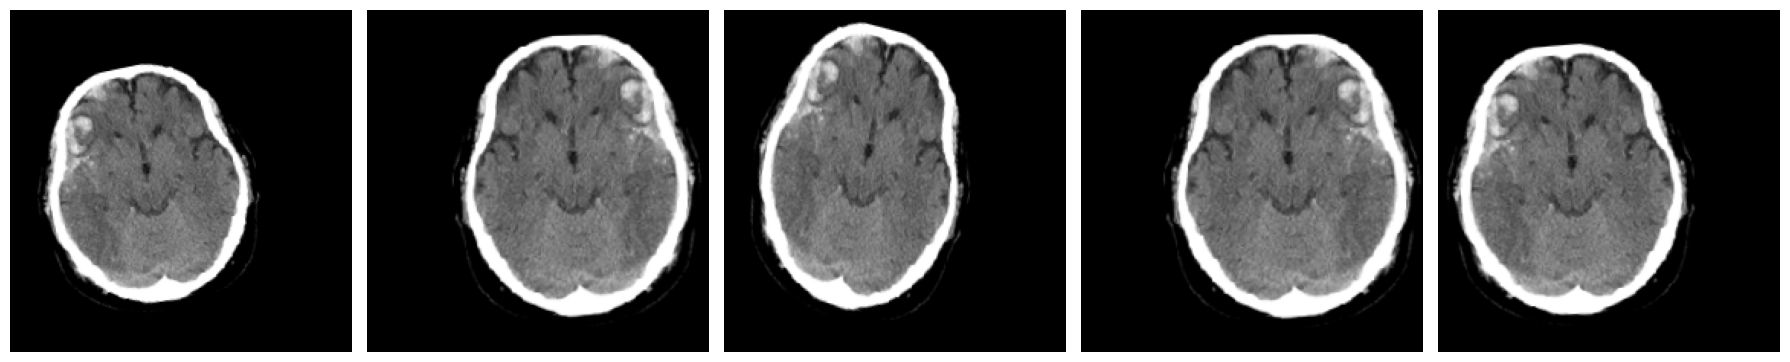

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)

train_generator = datagen.flow_from_directory(
    "RNSA-2500-each-class/Train",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)


valid_generator = val_gen.flow_from_directory(
    "RNSA-2500-each-class/Validation",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',

)


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(18,18))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


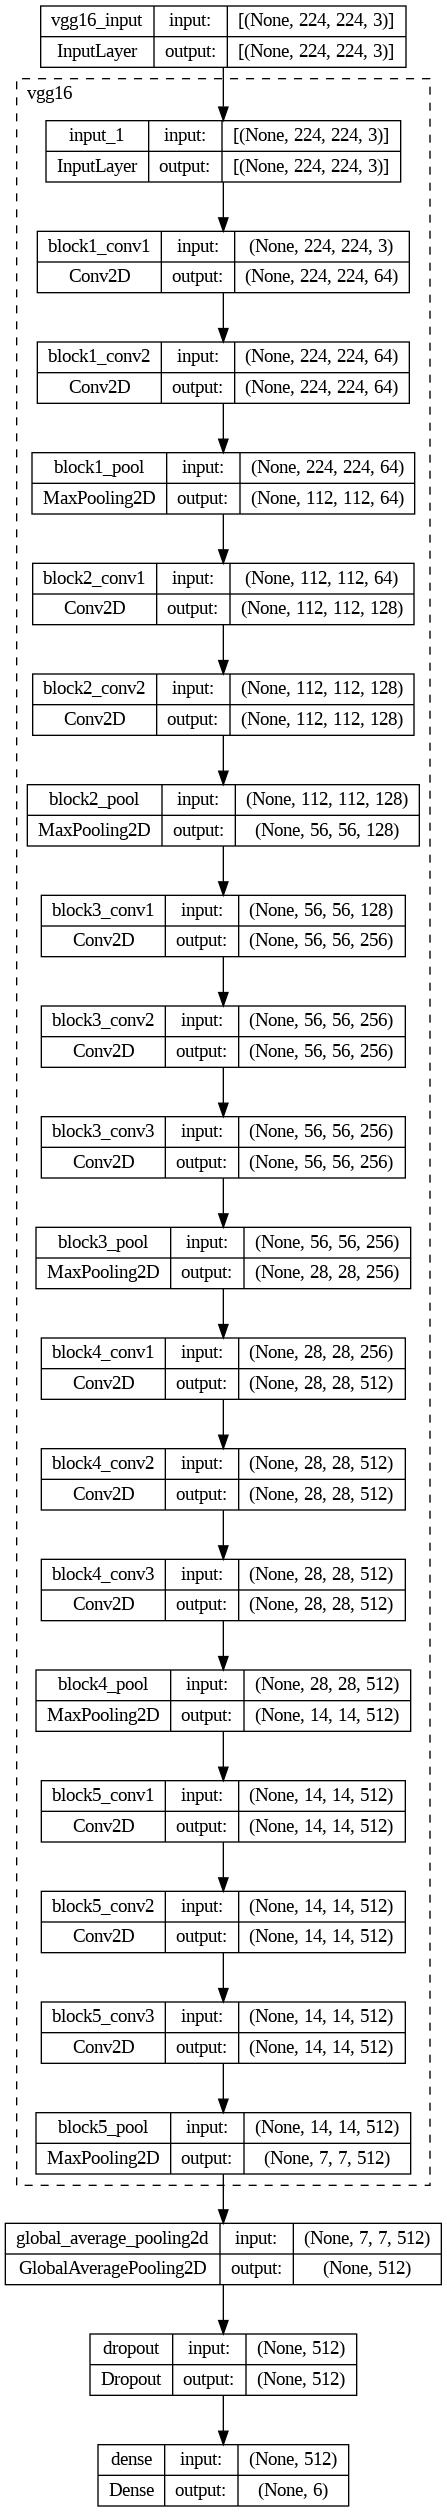

In [10]:
base_model = VGG16(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [11]:
#-----------Optimizers-----------#
# opt = SGD(lr=1e-4,momentum=0.99)
opt1 =adam = Adam(learning_rate = 0.0001)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=["accuracy"]
)



In [12]:
#-----------Training------------#
history = model.fit(
    train_generator,
    validation_data  = valid_generator,
    epochs = 40, 
    #  steps_per_epoch=train_generator.samples/32,
    #  validation_steps=valid_generator.samples/32
)

Epoch 1/40
352/352 [==============================] - 222s 573ms/step - loss: 0.4456 - accuracy: 0.6120 - val_loss: 0.4120 - val_accuracy: 0.6892
Epoch 2/40
352/352 [==============================] - 189s 536ms/step - loss: 0.4051 - accuracy: 0.7209 - val_loss: 0.3856 - val_accuracy: 0.7685
Epoch 3/40
352/352 [==============================] - 199s 563ms/step - loss: 0.3791 - accuracy: 0.7741 - val_loss: 0.3643 - val_accuracy: 0.8034
Epoch 4/40
352/352 [==============================] - 191s 542ms/step - loss: 0.3632 - accuracy: 0.8007 - val_loss: 0.3527 - val_accuracy: 0.8201
Epoch 5/40
352/352 [==============================] - 189s 536ms/step - loss: 0.3505 - accuracy: 0.8177 - val_loss: 0.3434 - val_accuracy: 0.8267
Epoch 6/40
352/352 [==============================] - 189s 536ms/step - loss: 0.3407 - accuracy: 0.8309 - val_loss: 0.3493 - val_accuracy: 0.8154
Epoch 7/40
352/352 [==============================] - 191s 540ms/step - loss: 0.3286 - accuracy: 0.8465 - val_loss: 0.3574 -

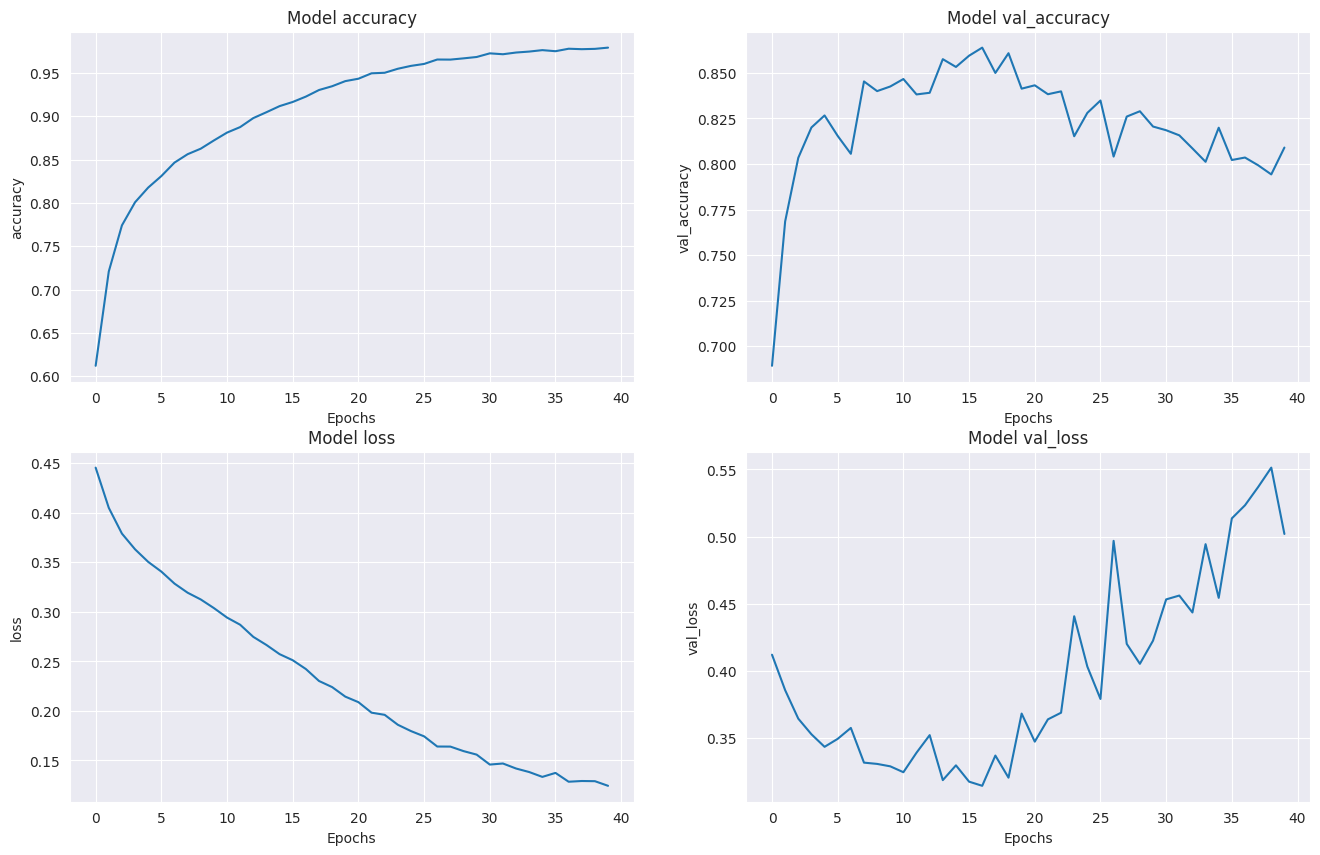

In [13]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","val_accuracy","loss","val_loss"]):
    ax[i].plot(history.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)

In [14]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_generator = test_gen.flow_from_directory(
    "RNSA-2500-each-class/Test",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)

Found 1500 images belonging to 6 classes.


In [15]:

classes = list(test_generator.class_indices.keys())
classes

['EDH', 'IPH', 'IVH', 'Normal', 'SAH', 'SDH']

In [16]:

Y_pred = model.predict(test_generator)

47/47 [==============================] - 10s 205ms/step


In [17]:

y_pred = np.argmax(Y_pred, axis=1)
y_true  =test_generator.classes
target_names = classes
cm = confusion_matrix(y_true, y_pred)

In [18]:
import itertools


from sklearn.metrics import classification_report, confusion_matrix
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

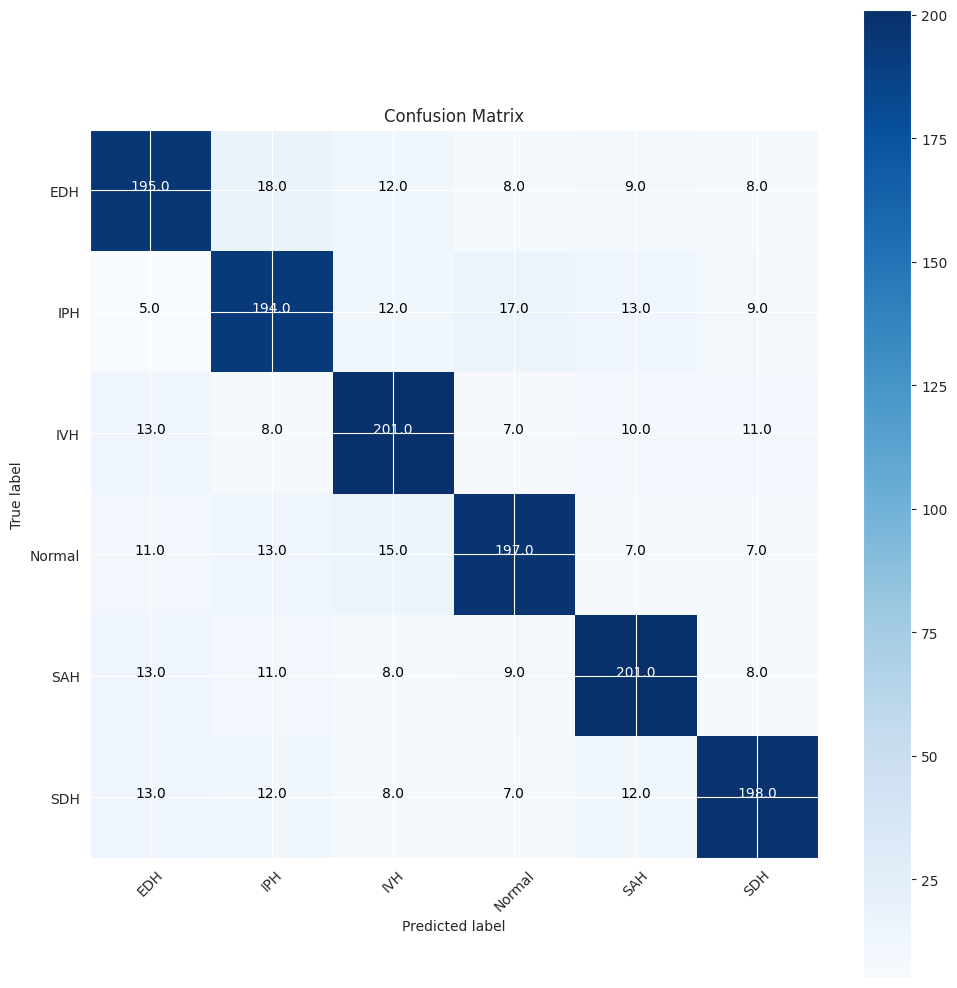

In [19]:

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
     

In [20]:

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         EDH       0.78      0.78      0.78       250
         IPH       0.76      0.78      0.77       250
         IVH       0.79      0.80      0.79       250
      Normal       0.80      0.79      0.80       250
         SAH       0.80      0.80      0.80       250
         SDH       0.82      0.79      0.81       250

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



In [21]:
def predict(img_rel_path,model):
    # Import Image from the path with size of (224, 224)
    img = image.load_img(img_rel_path, target_size=(224, 224))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])
    # Label array
    labels = {0: 'EDH', 1: 'IPH', 2: 'IVH', 3: 'Normal', 4: 'SAH', 5: 'SDH'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("pred:", predicted_class)
    print("correct :"+str(img_rel_path).split("/")[2], "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

In [22]:
dataset_path = 'RNSA-2500-each-class/Test'
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

test_file = []

for folder in folders:

    folder_name = os.path.basename(folder)
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    test_file += png_images


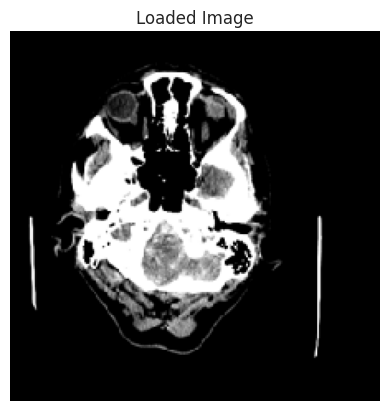

1/1 [==============================] - 0s 29ms/step


Maximum Probability:  0.99922323
pred: SAH
correct :SAH 



-------------------Individual Probability--------------------------------

EDH : 0.01 %
IPH : 0.0 %
IVH : 0.06 %
NORMAL : 0.0 %
SAH : 99.92 %
SDH : 0.01 %


In [33]:
predict(test_file[912],model)
     

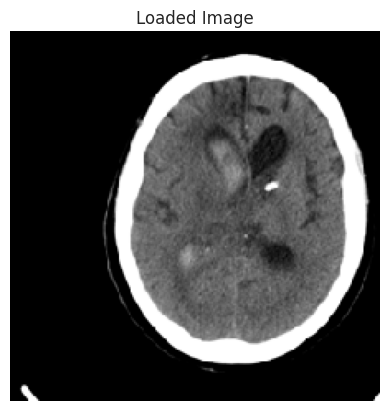

1/1 [==============================] - 0s 37ms/step


Maximum Probability:  0.9668996
pred: IVH
correct :IVH 



-------------------Individual Probability--------------------------------

EDH : 0.0 %
IPH : 2.97 %
IVH : 96.69 %
NORMAL : 0.0 %
SAH : 0.31 %
SDH : 0.01 %


In [38]:
predict(test_file[320],model)
     

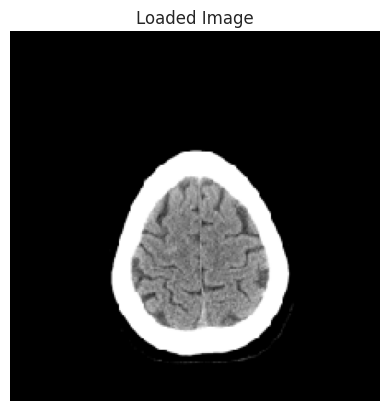

1/1 [==============================] - 0s 29ms/step


Maximum Probability:  0.983014
pred: SAH
correct :SAH 



-------------------Individual Probability--------------------------------

EDH : 0.06 %
IPH : 1.11 %
IVH : 0.21 %
NORMAL : 0.06 %
SAH : 98.3 %
SDH : 0.27 %


In [41]:
predict(test_file[855],model)
     